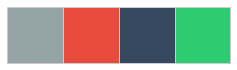

In [1]:
%matplotlib inline
from collections import OrderedDict
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.feature as cfeature
import seaborn as sns
sns.set_style('whitegrid')

import numpy as np
import pandas as pd
import xarray as xr

beg, end = '1990-01', '2014-12'
seasons = ['DJF', 'MAM', 'JJA', 'SON']

colors = OrderedDict()
colors['PHC'] = '#95a5a6'
colors['RASM-CONTROL'] = '#e74c3c'
colors['RASM-FAST'] = '#34495e'
colors['RASM-NOROF'] = '#2ecc71'

sns.palplot(sns.color_palette(colors.values()))


In [2]:
def clip_extended_ocean_grid(obj, x0=139, y0=133):
    nx = 1280
    ny = 720
    
    new = obj.isel(x=slice(x0, x0 + nx),
                   y=slice(y0, y0 + ny))
    new['x'] = np.arange(new.dims['x'])
    new['y'] = np.arange(new.dims['y'])
    
    return new

In [3]:
class Rasm(ccrs.Projection):

    def __init__(self):

        proj4_params = {'R': 6371200.0,
                        'lat_0': 90.0,
                        'lat_1': 90,
                        'lat_2': 90,
                        'lon_0': -114.0+360,
                        'proj': 'lcc',
                        'units': 'm',
                        'x_0': 9469302.950316086,
                        'y_0': 6201952.603370549}

        super(Rasm, self).__init__(proj4_params)

    @property
    def boundary(self):
        coords = ((self.x_limits[0], self.y_limits[0]),(self.x_limits[1], self.y_limits[0]),
                  (self.x_limits[1], self.y_limits[1]),(self.x_limits[0], self.y_limits[1]),
                  (self.x_limits[0], self.y_limits[0]))

        return ccrs.sgeom.Polygon(coords).exterior

    @property
    def threshold(self):
        return 100000.0

    @property
    def x_limits(self):
        return (0, 16423961.103252266)

    @property
    def y_limits(self):
        return (0, 12228062.194885937)

In [4]:
# Open RASM ocean files
mod_data = OrderedDict()
for sim, label in [('R1009RBRceap01a', 'RASM-CONTROL'), ('R1009RBRbslr01a', 'RASM-FAST'), ('R1009RBbaaa01a', 'RASM-NOROF')]:
    fname = '/raid2/jhamman/projects/RASM/data/processed/{0}/ocn/monthly_mean_timeseries/{0}.pop.hmm.197909-201412.nc'.format(sim)
    print(fname)
    mod_data[label] = xr.open_dataset(fname,
                                      decode_times=False, chunks={'time': 3}).rename({'nlon': 'x', 'nlat': 'y', 'z_t': 'depth'})
    mod_data[label]['time'] = pd.date_range('1979-09', '2014-12', freq='MS')
    mod_data[label]['depth'] /= 100  # convert to m from cm

# open PHC "Observations" 
ds_obs = xr.open_dataset('/raid2/jhamman/projects/RASM/data/compare/phc/phc3.0_monthly_ar9v4.nc',
                         decode_times=False).rename({'salt': 'SALT', 'temp': 'TEMP'})
ds_obs = clip_extended_ocean_grid(ds_obs)
ds_obs['time'] = pd.period_range('1979-09', freq='M', periods=12)


# open masks on ocean grid
ds_masks = xr.open_dataset('/raid2/jhamman/projects/RASM/data/inputdata/RASM_POPCICE_GRID_MASKS_AND_METRICS.nc')

/raid2/jhamman/projects/RASM/data/processed/R1009RBRceap01a/ocn/monthly_mean_timeseries/R1009RBRceap01a.pop.hmm.197909-201412.nc
/raid2/jhamman/projects/RASM/data/processed/R1009RBRbslr01a/ocn/monthly_mean_timeseries/R1009RBRbslr01a.pop.hmm.197909-201412.nc
/raid2/jhamman/projects/RASM/data/processed/R1009RBbaaa01a/ocn/monthly_mean_timeseries/R1009RBbaaa01a.pop.hmm.197909-201412.nc


In [5]:
mod_data[label]

<xarray.Dataset>
Dimensions:     (d2: 2, depth: 45, time: 424, x: 1280, y: 720)
Coordinates:
  * time        (time) datetime64[ns] 1979-09-01 1979-10-01 1979-11-01 ...
  * depth       (depth) float32 2.5 7.5 12.5 17.5 23.015 29.67 37.7 47.385 ...
    ULONG       (y, x) float64 -166.0 -166.0 -166.0 -165.9 -165.9 -165.9 ...
    ULAT        (y, x) float64 23.98 24.04 24.11 24.17 24.24 24.3 24.37 ...
    TLONG       (y, x) float64 194.0 194.1 194.1 194.1 194.1 194.1 194.2 ...
    TLAT        (y, x) float64 23.93 24.0 24.06 24.13 24.19 24.26 24.32 ...
  * d2          (d2) int64 0 1
  * y           (y) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
  * x           (x) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
Data variables:
    time_bound  (time, d2) float64 7.226e+05 7.226e+05 7.226e+05 7.226e+05 ...
    UVEL        (time, depth, y, x) float64 nan nan nan nan nan nan nan nan ...
    VVEL        (time, depth, y, x) float64 nan nan nan nan nan nan nan nan ...
 

In [8]:
plot_kwargs = dict(vmin=15, vmax=35, levels=12, extend='both', transform=ccrs.PlateCarree(), add_colorbar=False)

fig, axes = plt.subplots(1, 4, figsize=(12, 4), subplot_kw=dict(projection=Rasm()))
da_obs = ds_obs.SALT.isel(depth=0).groupby('time.season').mean('time')

for season, ax in zip(seasons, axes.flat):
    m = da_obs.sel(season=season).plot(x='xc', y='yc', ax=ax, **plot_kwargs)
    ax.set_title(season, fontsize=14)
    ax.coastlines(lw=0.7, resolution='110m', color='gray')

cbar_ax = fig.add_axes([0.1, 0.2, 0.8, 0.06])
cbar = plt.colorbar(m, orientation='horizontal', cax=cbar_ax)
cbar.set_label('Surface Salinity (-)')
cbar.set_label('Salt (-)', fontsize=14)

fig.tight_layout(h_pad=1.)

Error in callback <function post_execute at 0x2b5e362ee488> (for post_execute):


TypeError: unhashable type: 'MultiLineString'

TypeError: unhashable type: 'MultiLineString'

/usr/local/anaconda/lib/python2.7/site-packages/dask/array/numpy_compat.py:42: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)


AttributeError: Unknown property add_colorbar

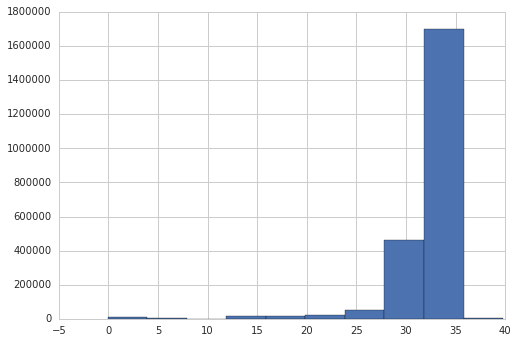

In [9]:
for label, ds_mod in mod_data.items():
    da_mod = ds_mod.SALT.isel(depth=0).sel(time=slice(beg, end)).groupby('time.season').mean('time')
    da_mod.plot(**plot_kwargs)
    plt.suptitle(label, y=1.01)

/home/jhamman/anaconda/envs/rasm/lib/python3.4/site-packages/dask/array/numpy_compat.py:44: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


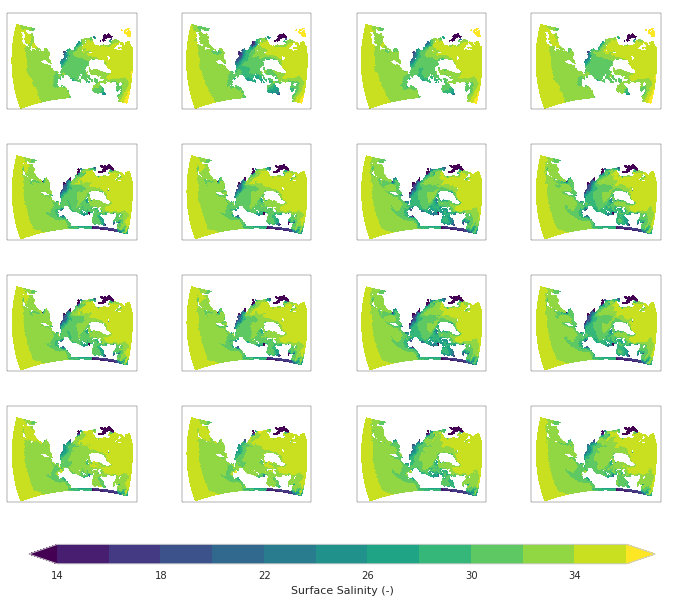

In [46]:
plot_kwargs = dict(vmin=15, vmax=35, levels=12, extend='both', transform=ccrs.PlateCarree(), add_colorbar=False)

fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(12, 9), subplot_kw=dict(projection=Rasm()))

mods = mod_data.keys()

da = ds_obs.SALT.isel(depth=0).groupby('time.season').mean('time')

[da.sel(season=s).plot(ax=ax, x='xc', y='yc', **plot_kwargs) for s, ax in zip(seasons, axes[0, :])]

for i, (label, ds) in enumerate(mod_data.items()):
    da = ds.SALT.isel(depth=0).sel(time=slice(beg, end)).groupby('time.season').mean('time')
    
    ms = [da.sel(season=s).plot(ax=ax, x='TLONG', y='TLAT', **plot_kwargs) for s, ax in zip(seasons, axes[i + 1, :])]

[ax.set_ylabel('') for ax in axes.flat]
axes[0, 0].set_ylabel('PHC')
[ax.set_ylabel(mod) for ax, mod in zip(axes[1:, 0], mods)]
[ax.set_xlabel('') for ax in axes.flat]
[ax.set_title('') for ax in axes.flat]
[ax.set_title(s) for ax, s in zip(axes[0], seasons)]

[ax.coastlines(lw=0.1, resolution='110m', color='gray') for ax in axes.flat]

# Add the colorbar
cbar_ax = fig.add_axes([0.15, -0.04, 0.725, 0.03])
cbar = plt.colorbar(ms[0], orientation='horizontal', cax=cbar_ax)
cbar.set_label('Surface Salinity (-)')

plt.tight_layout(pad=1)

/home/jhamman/anaconda/envs/rasm/lib/python3.4/site-packages/matplotlib/figure.py:1744: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "
/home/jhamman/anaconda/envs/rasm/lib/python3.4/site-packages/matplotlib/artist.py:221: MatplotlibDeprecationWarning: This has been deprecated in mpl 1.5, please use the
axes property.  A removal date has not been set.
  warnings.warn(_get_axes_msg, mplDeprecation, stacklevel=1)


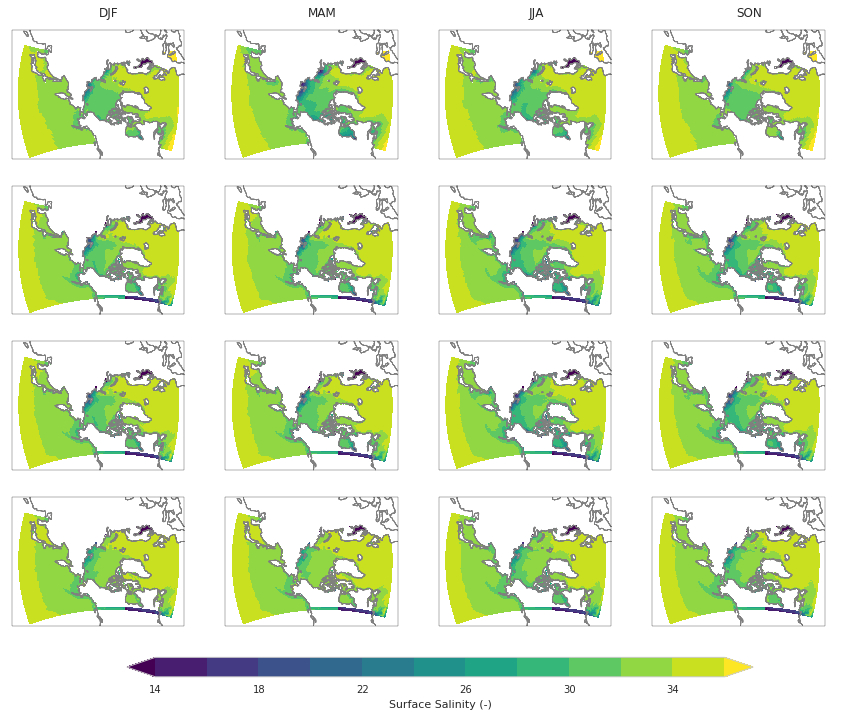

In [67]:
fig.tight_layout(pad=1.)
fig

/home/jhamman/anaconda/envs/rasm/lib/python3.4/site-packages/dask/array/numpy_compat.py:44: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/jhamman/anaconda/envs/rasm/lib/python3.4/site-packages/matplotlib/figure.py:1744: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "
/home/jhamman/anaconda/envs/rasm/lib/python3.4/site-packages/matplotlib/artist.py:221: MatplotlibDeprecationWarning: This has been deprecated in mpl 1.5, please use the
axes property.  A removal date has not been set.
  warnings.warn(_get_axes_msg, mplDeprecation, stacklevel=1)


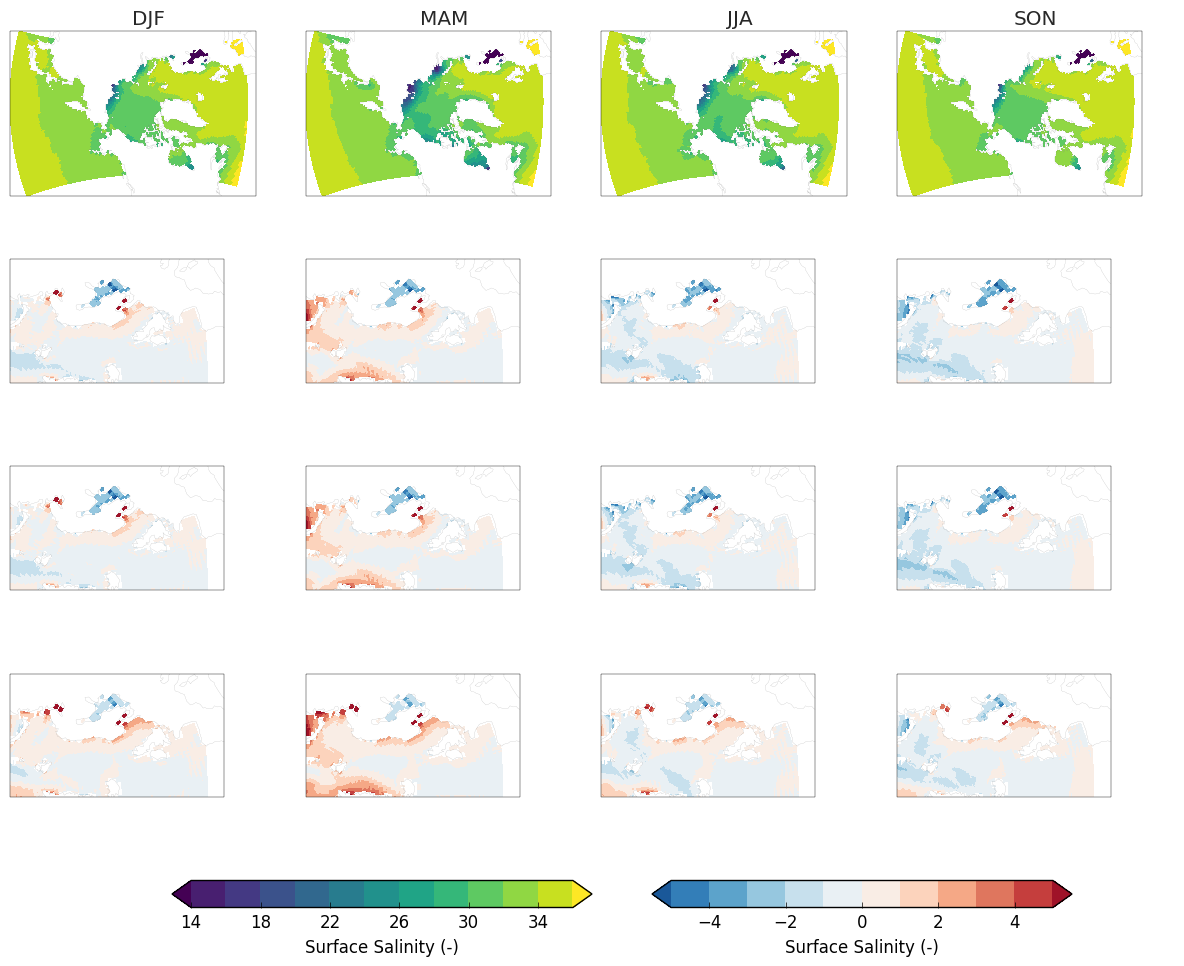

In [68]:
plot_anom_kwargs = dict(vmin=-5, vmax=5, levels=12, cmap='RdBu_r', transform=ccrs.PlateCarree(), add_colorbar=False)

fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(12, 9), subplot_kw=dict(projection=Rasm()))

mods = mod_data.keys()

da_obs = ds_obs.SALT.isel(depth=0).groupby('time.season').mean('time')

ams = [da_obs.sel(season=s).plot(ax=ax, x='xc', y='yc', **plot_kwargs) for s, ax in zip(seasons, axes[0, :])]

for i, (label, ds) in enumerate(mod_data.items()):
    da = ds.SALT.isel(depth=0).sel(time=slice(beg, end)).groupby('time.season').mean('time')
    
    ms = [(da.sel(season=s) - da_obs.sel(season=s)).plot(ax=ax, x='TLONG', y='TLAT', **plot_anom_kwargs) for s, ax in zip(seasons, axes[i + 1, :])]

[ax.set_ylabel('') for ax in axes.flat]
axes[0, 0].set_ylabel('PHC')
[ax.set_ylabel(mod + '- PHC') for ax, mod in zip(axes[1:, 0], mods)]
[ax.set_xlabel('') for ax in axes.flat]
[ax.set_title('') for ax in axes.flat]
[ax.set_title(s) for ax, s in zip(axes[0], seasons)]
[ax.coastlines(lw=0.1, resolution='110m', color='gray') for ax in axes.flat]

# Add the colorbars
cbar_ax = fig.add_axes([0.15, -0.04, 0.35, 0.03])
cbar = plt.colorbar(ams[0], orientation='horizontal', cax=cbar_ax)
cbar.set_label('Surface Salinity (-)')

cbar_ax = fig.add_axes([0.55, -0.04, 0.35, 0.03])
cbar = plt.colorbar(ms[0], orientation='horizontal', cax=cbar_ax)
cbar.set_label('Surface Salinity (-)')

fig.tight_layout()

In [8]:
# masks = ['mask_archipelago', 'mask_atlantic', 'mask_baffin', 'mask_baltic', 'mask_barents', 
#          'mask_bering', 'mask_canada', 'mask_centralarctic', 'mask_denmarkstrait', 'mask_greenland', 
#          'mask_hudsonbay', 'mask_japan', 'mask_kara', 'mask_labrador', 'mask_nansen', 
#          'mask_northsea', 'mask_norwegian', 'mask_okhotsk', 'mask_pacific', 'mask_shelf']

masks = ['mask_kara', 'mask_barents', 'mask_shelf', 'mask_canada', 'mask_centralarctic']

seasons = ['DJF', 'MAM', 'JJA', 'SON']

In [9]:
datasets = OrderedDict()

datasets['PHC'] = ds_obs.groupby('time.season').mean('time')
for label, ds_mod in mod_data.items():
    datasets[label] = ds_mod.sel(time=slice(beg, end)).groupby('time.season').mean('time')


/home/jhamman/anaconda/envs/rasm/lib/python3.4/site-packages/dask/array/numpy_compat.py:44: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/jhamman/anaconda/envs/rasm/lib/python3.4/site-packages/dask/array/numpy_compat.py:44: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/jhamman/anaconda/envs/rasm/lib/python3.4/site-packages/dask/array/numpy_compat.py:44: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/jhamman/anaconda/envs/rasm/lib/python3.4/site-packages/dask/array/numpy_compat.py:44: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/jhamman/anaconda/envs/rasm/lib/python3.4/site-packages/dask/array/numpy_compat.py:44: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/jhamman/anaconda/envs/rasm/lib/python3.4/site-packages/dask/array/numpy_compat.py:44: RuntimeWarning: in

KeyboardInterrupt: 

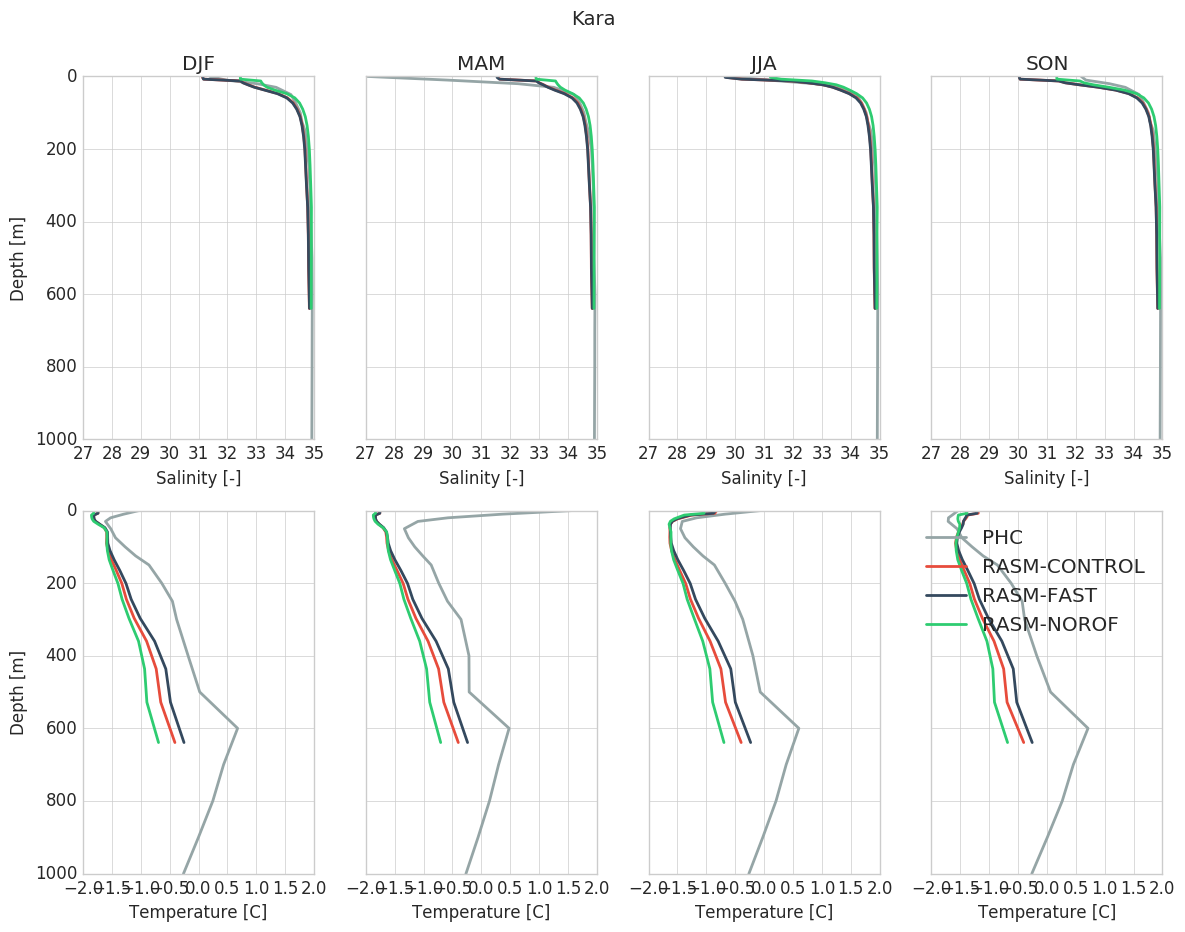

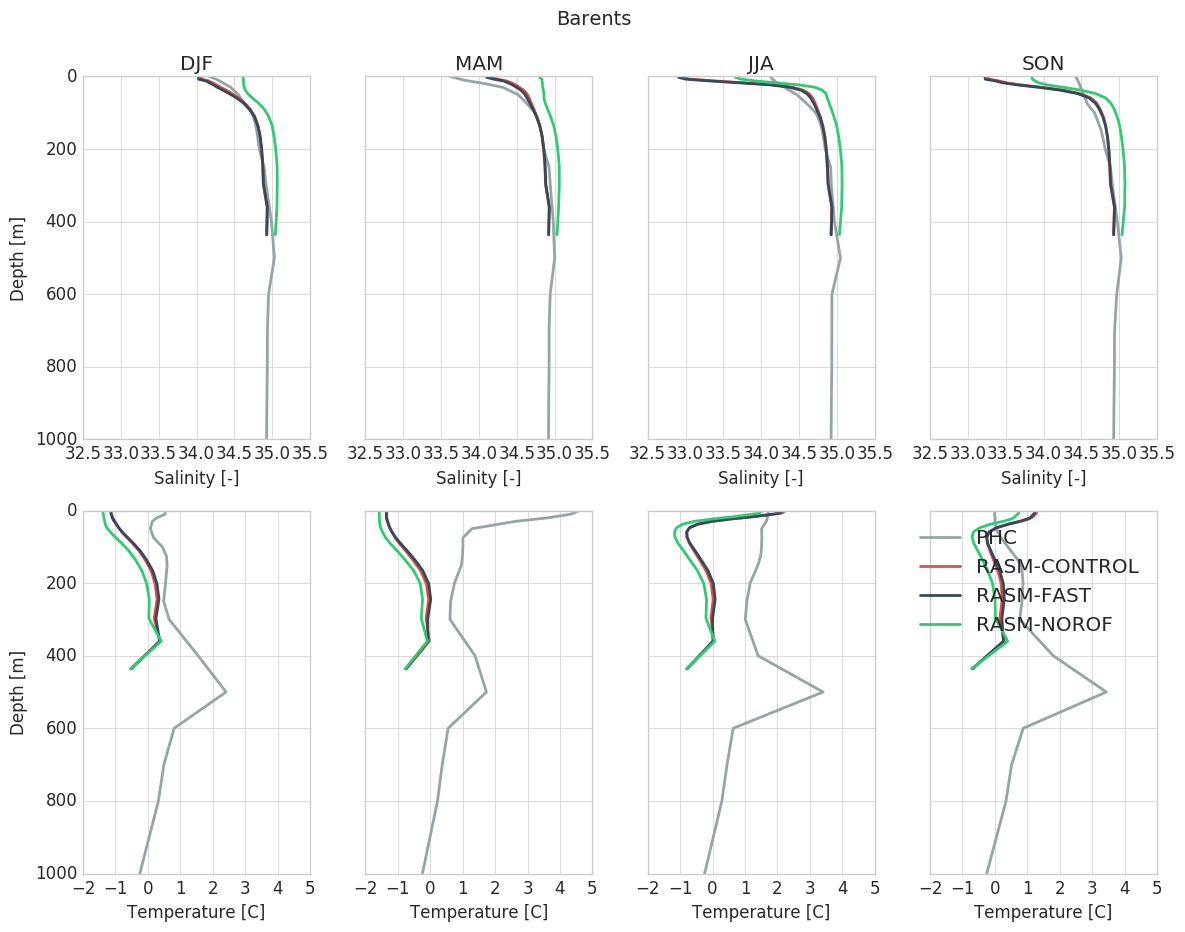

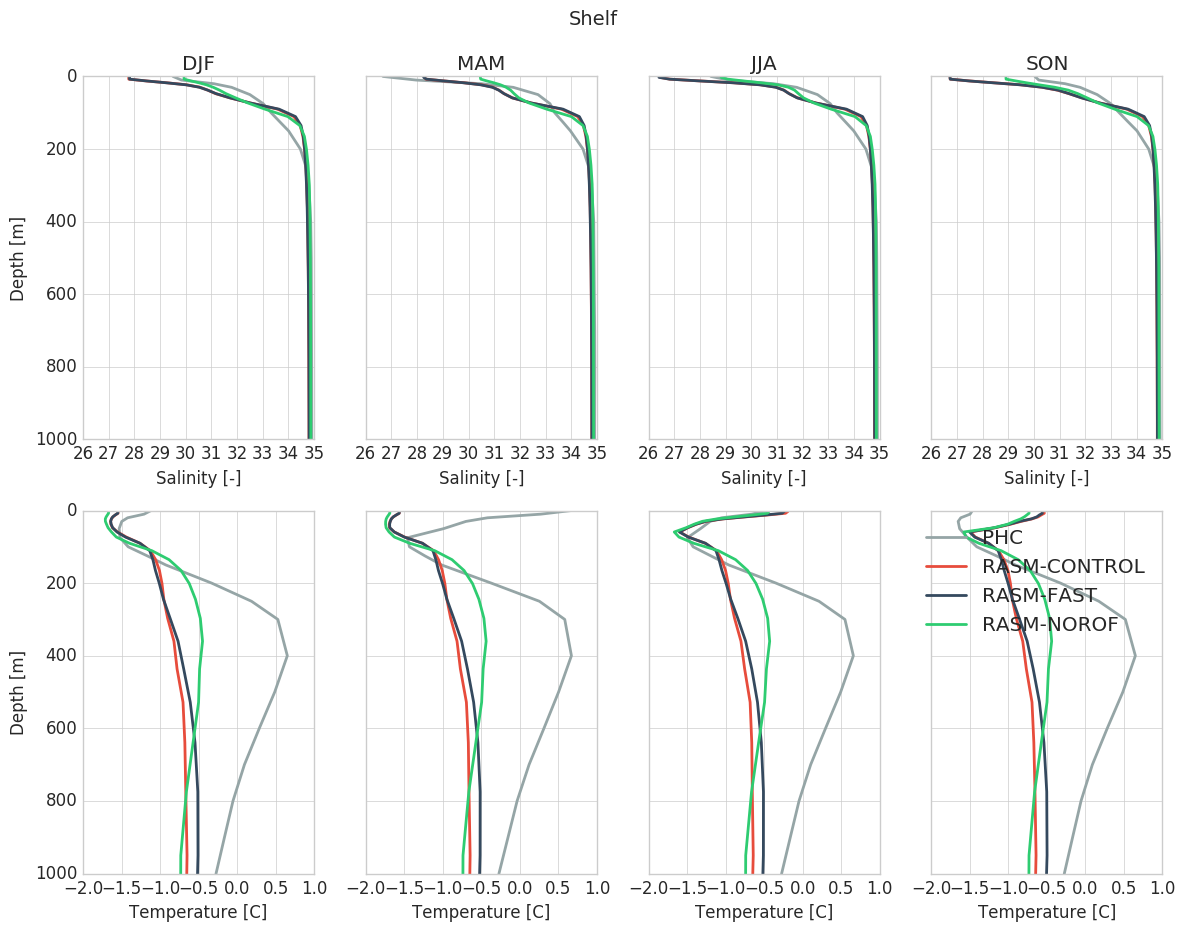

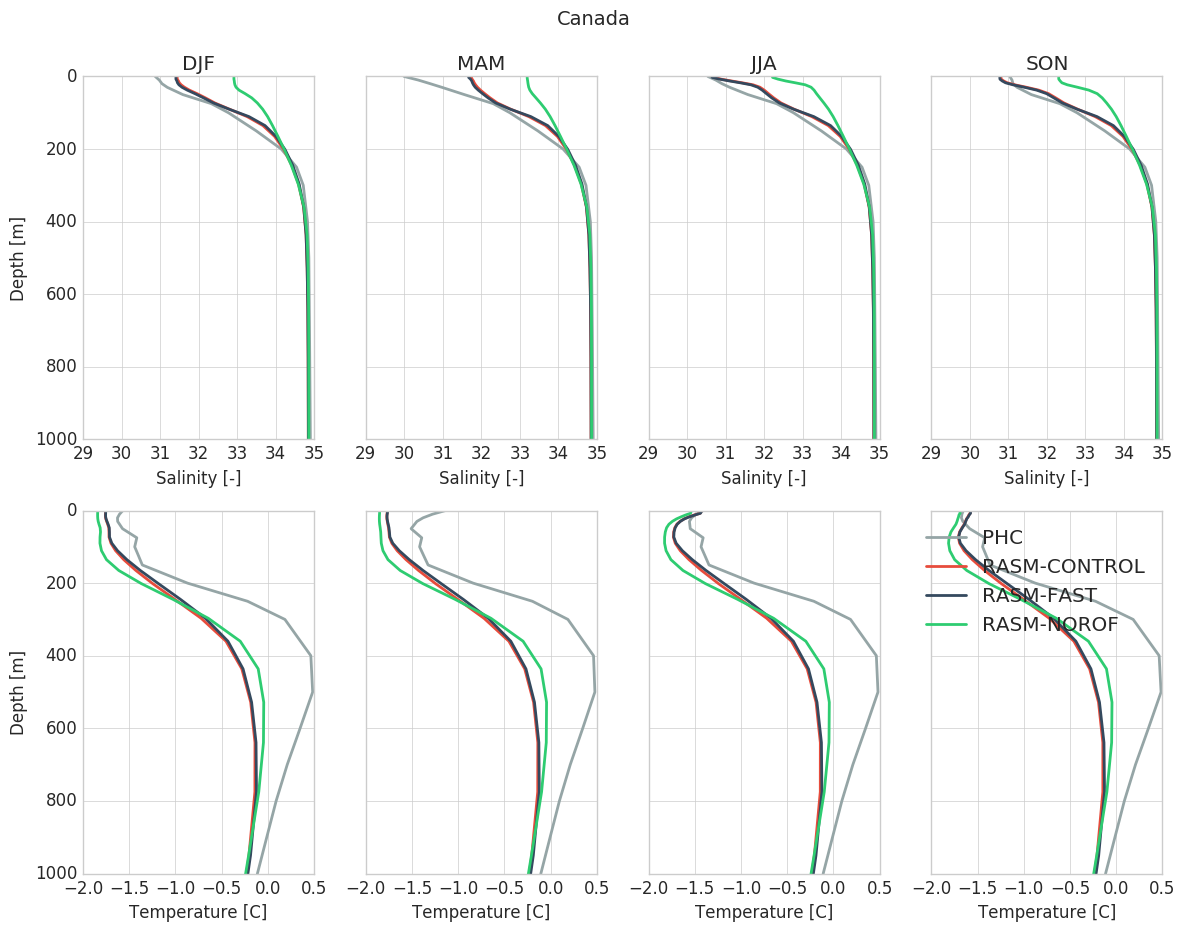

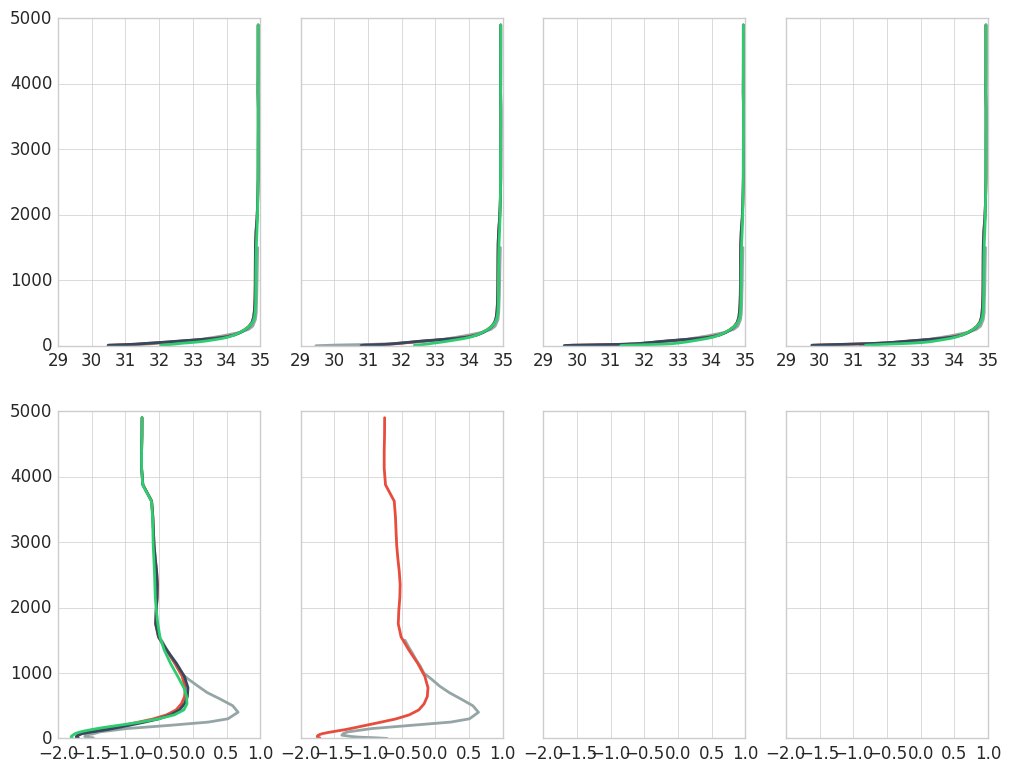

In [10]:
sns.set_style('whitegrid')

for mask in masks:

    fig, axes = plt.subplots(nrows=2, ncols=4, sharex='row', sharey=True, figsize=(12, 9))

    for i, var in enumerate(('SALT', 'TEMP')):
    
        for j, season, in enumerate(seasons):
            
            ax = axes[i, j]
            plt.sca(ax)      
            for label, ds in datasets.items():
                
                da = ds[var].sel(season=season).where(ds_masks[mask] == 1).mean(dim=('x', 'y'))
           
                ax.plot(da.values, da['depth'].values, label=label, color=colors[label], lw=2)

#     [ax.set_xlim(26, 36) for ax in axes[0, :]]
#     [ax.set_xlim(-3, 3) for ax in axes[1, :]]
    [ax.set_ylabel('Depth [m]') for ax in axes[:, 0]]
    [ax.set_xlabel('Temperature [C]') for ax in axes[1, :]]
    [ax.set_xlabel('Salinity [-]') for ax in axes[0, :]]
    [ax.set_title(title) for ax, title in zip(axes[0, :], seasons)]
    axes[0, 0].set_ylim(0, 1000)
    axes[0, 0].invert_yaxis()
    plt.legend()
    fig.suptitle(' '.join(mask.split('_')[1:]).title(), y='1.03', fontsize=14)
    plt.tight_layout()
